# Bi-LSTM Stock Price Prediction

# 0. Import Libraries

# 1. Preprocessing

## 1.0. Load Data

In [1]:
import pandas as pd
import numpy as np
import torch

class Data():
    def __init__(self):
        # 크롤링 데이터
        self.close = pd.read_csv('data/close.csv', thousands = ',', index_col = 0) # 종가
        self.close.index = pd.to_datetime(self.close.index) # 일자 datetime 타입으로 변환
        self.high = pd.read_csv('data/high.csv', thousands = ',', index_col = 0) # 고가
        self.high.index = pd.to_datetime(self.high.index)
        self.low = pd.read_csv('data/low.csv', thousands = ',', index_col = 0) # 저가
        self.low.index = pd.to_datetime(self.low.index)
        self.open = pd.read_csv('data/open.csv', thousands = ',', index_col = 0) # 시가
        self.open.index = pd.to_datetime(self.open.index)
        self.volume = pd.read_csv('data/volume.csv', thousands = ',', index_col = 0) # 거래량
        self.volume.index = pd.to_datetime(self.volume.index)
        
        self.market_equity_kospi = pd.read_csv('data/market_equity_kospi.csv', thousands = ',', index_col = 0) # 시가총액
        self.market_equity_kospi.index = pd.to_datetime(self.market_equity_kospi.index)
        
        self.top50 = pd.read_csv('data/top50.csv', thousands = ',', index_col = 0) # 시가총액 상위 50위
        
        self.stock_log_return = np.log(self.close).diff(1)

In [2]:
data = Data()

In [3]:
# log_return의 역연산
def inv_log_return(original, log_return):
    return original*np.exp(log_return)

## 1.1. Make Custom Dataset

In [4]:
data.close

,A005930,A373220,A000660,A207940,A005490,A005380,A051910,A006400,A000270,A035420,...,A138250,A144620,A152330,A192520,A192530,A900030,A900050,A950010,A950070,A950100
2000-01-04,6110,NaN,505463,NaN,142000,20700,NaN,50400,7350,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,5580,NaN,453444,NaN,149500,20800,NaN,47500,6950,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,5620,NaN,429889,NaN,144500,19700,NaN,43000,6650,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,5540,NaN,425963,NaN,145000,20300,NaN,41000,6500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,5770,NaN,422037,NaN,143000,20000,NaN,41600,6800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,69400,476000.0,117000,694000.0,539000,192900,509000.0,521000,82100,206500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-26,68600,475500.0,115000,680000.0,533000,190700,505000.0,522000,80900,201000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-27,68400,476500.0,114700,681000.0,535000,191100,496500.0,512000,81400,201500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-04,67500,456000.0,115400,691000.0,511000,190800,486000.0,484500,81900,191200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.top50

,2007-01-02,2007-01-30,2007-02-28,2007-03-29,2007-04-26,2007-05-28,2007-06-26,2007-07-25,2007-08-23,2007-09-20,...,2021-12-20,2022-01-18,2022-02-18,2022-03-22,2022-04-19,2022-05-18,2022-06-17,2022-07-15,2022-08-12,2022-09-14
0,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,...,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930,A005930
1,A015760,A005490,A005490,A005490,A005490,A005490,A005490,A005490,A005490,A005490,...,A000660,A000660,A373220,A373220,A373220,A373220,A373220,A373220,A373220,A373220
2,A005490,A015760,A060000,A060000,A060000,A060000,A060000,A015760,A015760,A009540,...,A207940,A035420,A000660,A000660,A000660,A000660,A000660,A000660,A000660,A000660
3,A060000,A060000,A015760,A015760,A015760,A015760,A009540,A060000,A009540,A015760,...,A035420,A207940,A035420,A207940,A207940,A207940,A207940,A207940,A207940,A207940
4,A055550,A055550,A055550,A055550,A055550,A009540,A015760,A009540,A060000,A060000,...,A035720,A051910,A207940,A035420,A035420,A035420,A051910,A005380,A051910,A051910
5,A017670,A053000,A053000,A053000,A053000,A055550,A055550,A055550,A055550,A055550,...,A051910,A006400,A051910,A035720,A035720,A006400,A035420,A035420,A035420,A005380
6,A053000,A017670,A017670,A017670,A009540,A053000,A053000,A053000,A053000,A017670,...,A006400,A005380,A035720,A005380,A006400,A005380,A006400,A006400,A006400,A006400
7,A000660,A005380,A005380,A000660,A017670,A017670,A017670,A005380,A000660,A053000,...,A005380,A035720,A005380,A006400,A005380,A035720,A005380,A051910,A005380,A035420
8,A005380,A000660,A000660,A009540,A000660,A005380,A005380,A000660,A017670,A005380,...,A000270,A000270,A006400,A051910,A051910,A051910,A035720,A000270,A035720,A000270
9,A030200,A030200,A009540,A005380,A034220,A034220,A000660,A017670,A005380,A034220,...,A323410,A105560,A000270,A000270,A000270,A000270,A000270,A035720,A000270,A035720


In [6]:
data.close

,A005930,A373220,A000660,A207940,A005490,A005380,A051910,A006400,A000270,A035420,...,A138250,A144620,A152330,A192520,A192530,A900030,A900050,A950010,A950070,A950100
2000-01-04,6110,NaN,505463,NaN,142000,20700,NaN,50400,7350,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,5580,NaN,453444,NaN,149500,20800,NaN,47500,6950,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,5620,NaN,429889,NaN,144500,19700,NaN,43000,6650,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,5540,NaN,425963,NaN,145000,20300,NaN,41000,6500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,5770,NaN,422037,NaN,143000,20000,NaN,41600,6800,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,69400,476000.0,117000,694000.0,539000,192900,509000.0,521000,82100,206500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-26,68600,475500.0,115000,680000.0,533000,190700,505000.0,522000,80900,201000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-27,68400,476500.0,114700,681000.0,535000,191100,496500.0,512000,81400,201500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-04,67500,456000.0,115400,691000.0,511000,190800,486000.0,484500,81900,191200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
from torch.utils.data import Dataset
from tsfm_public.toolkit.dataset import ForecastDFDataset
from sklearn.preprocessing import StandardScaler

class CustomDataset(ForecastDFDataset):
    def __init__(self, start_date, last_date, data=data, context_length=120, forecast_horizon=20):
        """
        start_date:str | 처음 리밸런싱 날짜. (train/val/test) 구분할 때 이용
        last_date:str | 마지막 리밸런싱 날짜. (train/val/test) 구분할 때 이용
        data | Data() 클래스의 인스턴스
        context_length:int | 예측에 사용할 영업일수 (default: 120일)
        forecast_horizon:int | 예측할 영업일수 (default: 20일)
        """
        self.start_date = start_date
        self.last_date = last_date
        
        self.top50 = data.top50
        self.close = data.close
        self.high = data.high
        self.low = data.low
        self.open = data.open
        self.volume = data.volume
        self.stock_log_return = data.stock_log_return

        self.context_length = context_length
        self.forecast_horizon = forecast_horizon

        self.index_list = [] # 데이터가 존재하는 index 리스트
        self.count_samples()

    def __len__(self):
        return len(self.index_list)

    def __getitem__(self, idx):
        index = self.index_list[idx] # 실제로 데이터가 존재하는 index를 택한다.
        column = index // self.top50.shape[0]
        row = index % self.top50.shape[0]
        company = self.top50.iloc[row, column] # 주식회사 번호
        date = self.top50.columns[column] # 리밸런싱 날짜
        index_number = self.close.index.get_loc(date) # close에서 리밸런싱에 해당하는 날짜의 index 위치를 찾는다.

        # 과거 데이터
        past_close = self.close[company][index_number-(self.context_length-1):index_number+1].values # context_length(default=120)에 해당하는 close
        past_high = self.high[company][index_number-(self.context_length-1):index_number+1].values
        past_low = self.low[company][index_number-(self.context_length-1):index_number+1].values
        past_open = self.open[company][index_number-(self.context_length-1):index_number+1].values
        past_volume = self.volume[company][index_number-(self.context_length-1):index_number+1].values
        past_values = np.column_stack([past_close, past_high, past_low, past_open, past_volume])

        # 정규화
        scaler = StandardScaler()
        past_values = scaler.fit_transform(past_values) # close, high, low, open, volumn에 대해서 정규화
        past_values = torch.Tensor(past_values) # 텐서로 변환

        # 예측할 데이터
        """
        future_close = self.close[company][index_number:index_number+self.forecast_horizon].values
        future_high = self.high[company][index_number:index_number+self.forecast_horizon].values
        future_low = self.low[company][index_number:index_number+self.forecast_horizon].values
        future_open = self.open[company][index_number:index_number+self.forecast_horizon].values
        future_volume = self.volume[company][index_number:index_number+self.forecast_horizon].values
        """
        future_stock_log_return = self.stock_log_return[company][index_number:index_number+self.forecast_horizon].values
            # forecast_horizon(default=20)에 해당하는 stock_log_return

        # 정규화
        future_values = torch.Tensor(future_stock_log_return) # 텐서로 변환
            # 추후에 학습 시 future_stock_log_return만 예측하도록 설정할 예정

        return {'past_values': past_values,
                'future_values': future_values,
                'scaler': scaler,
                'timestamp': np.datetime64(date)}

    def count_samples(self):
        """
        count_samples는 데이터의 전체 개수를 파악하는 함수이다.
        만약 중간에 데이터를 생성하다가 context_length에 해당하는 영업일수 만큼의 주가 데이터가 존재하지 않는다면
        해당 데이터는 데이터셋에 포함시키지 않는다.
        이를 미리 고려하여 CustomDataset의 __len__에서 반환할 데이터의 크기를 해당 함수에서 미리 결정해준다.
        """
        for idx in range(self.top50.size):
            column = idx // self.top50.shape[0]
            row = idx % self.top50.shape[0]
            company = self.top50.iloc[row, column] # 주식회사 번호
            date = self.top50.columns[column] # 리밸런싱 날짜
            if date < self.start_date:
                continue
            elif date > self.last_date: 
                break
            index_number = self.close.index.get_loc(date) # close에서 리밸런싱에 해당하는 날짜의 index 위치를 찾는다.
            if (index_number >= self.context_length-1 and company != 'A060000'): # 만약 index_number가 context_length-1(default=119)보다 크거나 같으면
                # 참고: 'A060000' 회사는 국민은행으로, 주식병합에 따라 데이터가 존재하지 않음.
                close_values = self.close[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                high_values = self.high[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                low_values = self.low[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                open_values = self.open[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                volume_values = self.volume[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                stock_log_return_values = self.stock_log_return[company][index_number-(self.context_length-1):index_number+self.forecast_horizon].values
                values = np.column_stack([close_values, high_values, low_values, open_values, volume_values, stock_log_return_values])
                if not np.isnan(values).any(): # 만약 주가 데이터 중 Nan이 존재하지 않으면
                    self.index_list.append(idx)
        return len(self.index_list)

In [9]:
train_dataset = CustomDataset(start_date='2007-01-01', last_date='2012-12-31')
valid_dataset = CustomDataset(start_date='2013-01-01', last_date='2014-12-31')
test_dataset = CustomDataset(start_date='2020-01-01', last_date='2022-09-04')

In [10]:
len(train_dataset)

3688

In [11]:
train_dataset[0]

{'past_values': tensor([[-1.2755, -1.2943, -1.1229, -1.2677, -0.3877],
         [-1.0547, -1.2508, -1.6111, -1.5693,  0.1683],
         [-0.9664, -1.0335, -1.3892, -1.5693,  0.0098],
         [-0.9664, -1.0335, -1.1673, -1.0523,  1.0502],
         [-1.3197, -1.1639, -1.3448, -1.3108,  1.1024],
         [-2.0263, -1.9463, -1.9218, -1.8709,  1.1931],
         [-2.1146, -2.2506, -2.1881, -2.3448, -0.2624],
         [-2.2029, -2.0767, -2.0106, -2.1725, -0.4176],
         [-1.4080, -1.6420, -1.5667, -1.5693,  0.8336],
         [-1.4522, -1.6855, -1.5667, -1.6986, -1.1079],
         [-1.8496, -1.8159, -1.8774, -1.8709, -0.2196],
         [-1.4080, -1.4682, -1.3892, -1.4832, -0.0264],
         [-1.3639, -1.3812, -1.3004, -1.3970, -1.4505],
         [-1.1431, -1.3378, -1.3892, -1.3539, -0.2481],
         [-1.3197, -1.3812, -1.2561, -1.3108, -1.1150],
         [-0.9664, -0.9465, -0.7678, -0.8800,  1.7147],
         [-1.0989, -0.9031, -0.9010, -0.9231, -0.5509],
         [-0.9222, -0.9465, -1.03

## 1.2. Set Seed

In [12]:
import pandas as pd
import numpy as np

import random
import os
import torch

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print('seed:', seed)

In [13]:
seed_everything()

seed: 42


## 1.3. Make DataLoader

In [14]:
batch_size = 64

In [15]:
def collate_fn(batch):
    past_values = torch.stack([b['past_values'] for b in batch])
    future_values = torch.stack([b['future_values'] for b in batch])
    timestamp = [b['timestamp'] for b in batch]
    scaler = [b['scaler'] for b in batch]
    return {'past_values': past_values,
            'future_values': future_values,
            'timestamp': timestamp,
            'scaler': scaler}

In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [17]:
next(iter(train_dataloader))

{'past_values': tensor([[[-1.2755, -1.2943, -1.1229, -1.2677, -0.3877],
          [-1.0547, -1.2508, -1.6111, -1.5693,  0.1683],
          [-0.9664, -1.0335, -1.3892, -1.5693,  0.0098],
          ...,
          [-0.7898, -0.9465, -0.9454, -0.8369, -1.1127],
          [-0.7456, -0.7292, -0.6791, -0.6215, -0.9409],
          [-0.2157, -0.3814, -0.4128, -0.4491,  0.1453]],
 
         [[-1.0972, -1.1245, -1.1533, -1.0272, -0.1102],
          [-1.1955, -1.1489, -1.3078, -1.1555,  0.1219],
          [-1.1463, -1.1732, -1.1275, -1.1299, -0.2163],
          ...,
          [ 1.9264,  2.2083,  2.1681,  2.5152, -0.5340],
          [ 2.4426,  2.3300,  1.9879,  2.1815, -0.1684],
          [ 3.3029,  3.2058,  3.1208,  3.0285,  0.1978]],
 
         [[-0.4144, -0.3855, -0.3982, -0.3161, -0.4312],
          [-0.4338, -0.5004, -0.6553, -0.6115,  1.2240],
          [-0.5110, -0.5004, -0.6157, -0.4342,  0.8121],
          ...,
          [ 1.8655,  2.0837,  2.0146,  2.2440, -0.7387],
          [ 1.9427,  2

# 2. Model

In [18]:
context_length = 120 # 모델이 참조할 데이터 길이 (original: 512)
forecast_horizon = 20 # 모델이 예측할 데이터 길이 (original: 96)
patch_length = 15 # 모델의 patch 길이. context_length의 약수여야 한다. (original: 16)
num_workers = 1 # dataloader worker 개수

In [19]:
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class BiLSTM(nn.Module):
    def __init__(self, input_dim, latent_dim, num_layers, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, latent_dim, num_layers=num_layers, bidirectional=True, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(2*latent_dim, output_dim)  # 2*latent_dim because of bidirectionality

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        final_output = lstm_out[:, -1, :]
        return self.fc(final_output)

input_dim = 5
latent_dim = 50
num_layers = 4
output_dim = 1

model = BiLSTM(input_dim, latent_dim, num_layers, output_dim)
model.to(device)

model

BiLSTM(
  (lstm): LSTM(5, 50, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

# 3. Training

In [20]:
from torch.optim import Adam
from transformers import get_scheduler

epochs = 30
learning_rate=0.001
one_epoch_steps = len(train_dataloader)
# warmup_steps = one_epoch_steps * 5

# optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# learning rate scheduler
# lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs*one_epoch_steps)

# loss function
loss_fn = nn.MSELoss()

In [21]:
from tqdm.auto import tqdm
import json

train_loss_list = []
train_mae_list = []
train_mape_list = []
train_acc_list = []
train_precision_list = []
train_recall_list = []
train_f1score_list = []

valid_loss_list = []
valid_mae_list = []
valid_mape_list = []
valid_acc_list = []
valid_precision_list = []
valid_recall_list = []
valid_f1score_list = []

for epoch in range(1, epochs+1):
    model.train()
    progress_bar = tqdm(range(len(train_dataloader)))
    train_loss = 0 # MSE
    train_mae = 0
    train_mape = 0
    train_acc = 0
    train_precision = 0
    train_recall = 0
    train_f1score = 0
    for batch in train_dataloader:
        past_values = batch['past_values'].to(device)
        future_values = batch['future_values'].to(device)

        outputs = model(past_values)
        sum_future_values = torch.sum(future_values, dim=1)
        if outputs.shape[0] == 1:
            pred = outputs.squeeze(-1)
        else:
            pred = outputs.squeeze()
        label = sum_future_values

        scaler_list = batch['scaler']
        past_close = []
        for scaler, past_value in zip(scaler_list, past_values):
            close = scaler.inverse_transform(past_value.to('cpu'))[-1, 1] # 리밸런싱 시점의 종가를 복구
            past_close.append(close)
        past_close = torch.tensor(past_close)
        future_close = inv_log_return(past_close, pred.detach().to('cpu'))
        label_close = inv_log_return(past_close, label.detach().to('cpu'))
        
        tp = sum((pred > 0) & (label > 0)).item()/len(pred)
        fp = sum((pred > 0) & (label < 0)).item()/len(pred)
        fn = sum((pred < 0) & (label > 0)).item()/len(pred)
        tn = sum((pred < 0) & (label < 0)).item()/len(pred)
        
        loss = loss_fn(pred, label)
        mae = torch.mean(torch.abs(pred - label))
        mape = torch.mean(torch.abs(label_close-future_close)/label_close)
        acc = (tp + tn) / ((tp + fp + fn + tn)+1e-8)
        precision = tp / ((tp + fp)+1e-8)
        recall = tp / ((tp + fn)+1e-8)
        f1score = 2 / ((1/(precision+1e-8))+(1/(recall+1e-8)))

        loss.backward()

        optimizer.step()
        # lr_scheduler.step()
        optimizer.zero_grad()

        train_loss += loss.item() / len(train_dataloader)
        train_mae += mae.item() / len(train_dataloader)
        train_mape += mape.item() / len(train_dataloader)
        train_acc += acc / len(train_dataloader)
        train_precision += precision / len(train_dataloader)
        train_recall += recall / len(train_dataloader)
        train_f1score += f1score / len(train_dataloader)

        progress_bar.update(1)

    model.eval()
    progress_bar = tqdm(range(len(valid_dataloader)))
    valid_loss = 0
    valid_mae = 0
    valid_mape = 0
    valid_acc = 0
    valid_precision = 0
    valid_recall = 0
    valid_f1score = 0
    for batch in valid_dataloader:
        past_values = batch['past_values'].to(device)
        future_values = batch['future_values'].to(device)
        
        outputs = model(past_values)
        sum_future_values = torch.sum(future_values, dim=1)
        if outputs.shape[0] == 1:
            pred = outputs.squeeze(-1)
        else:
            pred = outputs.squeeze()
        label = sum_future_values

        scaler_list = batch['scaler']
        past_close = []
        for scaler, past_value in zip(scaler_list, past_values):
            close = scaler.inverse_transform(past_value.to('cpu'))[-1, 1] # 리밸런싱 시점의 종가를 복구
            past_close.append(close)
        past_close = torch.tensor(past_close)
        future_close = inv_log_return(past_close, pred.detach().to('cpu'))
        label_close = inv_log_return(past_close, label.detach().to('cpu'))
        
        tp = sum((pred > 0) & (label > 0)).item()/len(pred)
        fp = sum((pred > 0) & (label < 0)).item()/len(pred)
        fn = sum((pred < 0) & (label > 0)).item()/len(pred)
        tn = sum((pred < 0) & (label < 0)).item()/len(pred)
        
        loss = loss_fn(pred, label)
        mae = torch.mean(torch.abs(pred - label))
        mape = torch.mean(torch.abs(label_close-future_close)/label_close)
        acc = (tp + tn) / ((tp + fp + fn + tn)+1e-8)
        precision = tp / ((tp + fp)+1e-8)
        recall = tp / ((tp + fn)+1e-8)
        f1score = 2 / ((1/(precision+1e-8))+(1/(recall+1e-8)))

        valid_loss += loss.item() / len(valid_dataloader)
        valid_mae += mae.item() / len(valid_dataloader)
        valid_mape += mape.item() / len(valid_dataloader)
        valid_acc += acc / len(valid_dataloader)
        valid_precision += precision / len(valid_dataloader)
        valid_recall += recall / len(valid_dataloader)
        valid_f1score += f1score / len(valid_dataloader)

        progress_bar.update(1)

    train_loss_list.append(train_loss)
    train_mae_list.append(train_mae)
    train_mape_list.append(train_mape)
    train_acc_list.append(train_acc)
    train_precision_list.append(train_precision)
    train_recall_list.append(train_recall)
    train_f1score_list.append(train_f1score)
    
    valid_loss_list.append(valid_loss)
    valid_mae_list.append(valid_mae)
    valid_mape_list.append(valid_mape)
    valid_acc_list.append(valid_acc)
    valid_precision_list.append(valid_precision)
    valid_recall_list.append(valid_recall)
    valid_f1score_list.append(valid_f1score)
    
    print(f"[epoch {epoch}]")
    print(f"|| train || loss: {train_loss:.7f} | mae: {train_mae:.7f} | mape: {train_mape:.5f} | acc: {train_acc:.5f} | f1 score: {train_f1score:.5f} |")
    print(f"|| valid || loss: {valid_loss:.7f} | mae: {valid_mae:.7f} | mape: {valid_mape:.5f} | acc: {valid_acc:.5f} | f1 score: {valid_f1score:.5f} |")

    folder_path = 'ckpt_biLSTM/model_cross_01'
    os.makedirs(folder_path, exist_ok=True)
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch
    }, os.path.join(folder_path, f'ckpt-{epoch}.pt'))

best_epoch = int(np.argmin(valid_loss_list)+1)
data = {'train_loss_list': train_loss_list,
        'train_mae_list': train_mae_list,
        'train_mape_list': train_mape_list,
        'train_acc_list': train_acc_list,
        'train_precision_list': train_precision_list,
        'train_recall_list': train_recall_list,
        'train_f1score_list': train_f1score_list,
        'valid_loss_list': valid_loss_list,
        'valid_mae_list': valid_mae_list,
        'valid_mape_list': valid_mape_list,
        'valid_acc_list': valid_acc_list,
        'valid_precision_list': valid_precision_list,
        'valid_recall_list': valid_recall_list,
        'valid_f1score_list': valid_f1score_list,
        'best_epoch': best_epoch,
       }
print('best_epoch:', best_epoch)

# JSON 파일로 저장
with open('ckpt_TS/model_cross_01/loss.json', 'w') as json_file:
    json.dump(data, json_file)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 1]
|| train || loss: 0.0137136 | mae: 0.0888368 | mape: 0.08982 | acc: 0.51175 | f1 score: 0.42501 |
|| valid || loss: 0.0063249 | mae: 0.0611337 | mape: 0.06067 | acc: 0.51653 | f1 score: 0.00000 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 2]
|| train || loss: 0.0129905 | mae: 0.0859488 | mape: 0.08691 | acc: 0.44534 | f1 score: 0.35295 |
|| valid || loss: 0.0060956 | mae: 0.0595110 | mape: 0.05980 | acc: 0.51653 | f1 score: 0.00000 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 3]
|| train || loss: 0.0128181 | mae: 0.0854264 | mape: 0.08633 | acc: 0.45493 | f1 score: 0.35296 |
|| valid || loss: 0.0060973 | mae: 0.0595602 | mape: 0.05979 | acc: 0.51653 | f1 score: 0.00000 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 4]
|| train || loss: 0.0127611 | mae: 0.0851850 | mape: 0.08606 | acc: 0.45158 | f1 score: 0.36926 |
|| valid || loss: 0.0060859 | mae: 0.0594021 | mape: 0.05982 | acc: 0.51496 | f1 score: 0.00000 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 5]
|| train || loss: 0.0127066 | mae: 0.0850463 | mape: 0.08591 | acc: 0.45461 | f1 score: 0.38652 |
|| valid || loss: 0.0060858 | mae: 0.0593708 | mape: 0.05986 | acc: 0.52361 | f1 score: 0.07854 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 6]
|| train || loss: 0.0126697 | mae: 0.0849475 | mape: 0.08581 | acc: 0.45724 | f1 score: 0.39783 |
|| valid || loss: 0.0060884 | mae: 0.0593591 | mape: 0.05989 | acc: 0.52753 | f1 score: 0.12919 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 7]
|| train || loss: 0.0126502 | mae: 0.0848859 | mape: 0.08575 | acc: 0.46280 | f1 score: 0.40924 |
|| valid || loss: 0.0060896 | mae: 0.0593489 | mape: 0.05990 | acc: 0.53378 | f1 score: 0.19955 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 8]
|| train || loss: 0.0126280 | mae: 0.0848346 | mape: 0.08569 | acc: 0.45579 | f1 score: 0.40491 |
|| valid || loss: 0.0060894 | mae: 0.0593434 | mape: 0.05990 | acc: 0.53226 | f1 score: 0.17809 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 9]
|| train || loss: 0.0126218 | mae: 0.0847882 | mape: 0.08565 | acc: 0.45339 | f1 score: 0.40251 |
|| valid || loss: 0.0060887 | mae: 0.0593378 | mape: 0.05990 | acc: 0.52907 | f1 score: 0.21258 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 10]
|| train || loss: 0.0125910 | mae: 0.0846983 | mape: 0.08556 | acc: 0.45983 | f1 score: 0.41401 |
|| valid || loss: 0.0060874 | mae: 0.0593323 | mape: 0.05988 | acc: 0.53226 | f1 score: 0.18135 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 11]
|| train || loss: 0.0125813 | mae: 0.0846697 | mape: 0.08552 | acc: 0.45735 | f1 score: 0.42004 |
|| valid || loss: 0.0060916 | mae: 0.0593272 | mape: 0.05994 | acc: 0.52824 | f1 score: 0.27719 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 12]
|| train || loss: 0.0125713 | mae: 0.0846259 | mape: 0.08549 | acc: 0.45987 | f1 score: 0.42510 |
|| valid || loss: 0.0060902 | mae: 0.0593216 | mape: 0.05994 | acc: 0.52744 | f1 score: 0.29211 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 13]
|| train || loss: 0.0125473 | mae: 0.0845693 | mape: 0.08543 | acc: 0.46436 | f1 score: 0.43180 |
|| valid || loss: 0.0060922 | mae: 0.0593273 | mape: 0.05994 | acc: 0.52128 | f1 score: 0.26981 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 14]
|| train || loss: 0.0125596 | mae: 0.0846815 | mape: 0.08556 | acc: 0.45501 | f1 score: 0.41380 |
|| valid || loss: 0.0060839 | mae: 0.0593295 | mape: 0.05983 | acc: 0.52754 | f1 score: 0.12536 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 15]
|| train || loss: 0.0125538 | mae: 0.0846139 | mape: 0.08546 | acc: 0.44698 | f1 score: 0.40887 |
|| valid || loss: 0.0060868 | mae: 0.0593140 | mape: 0.05990 | acc: 0.53062 | f1 score: 0.24469 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 16]
|| train || loss: 0.0125165 | mae: 0.0845025 | mape: 0.08535 | acc: 0.45761 | f1 score: 0.42654 |
|| valid || loss: 0.0060913 | mae: 0.0593292 | mape: 0.05993 | acc: 0.54213 | f1 score: 0.33032 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 17]
|| train || loss: 0.0124929 | mae: 0.0844038 | mape: 0.08528 | acc: 0.47126 | f1 score: 0.44627 |
|| valid || loss: 0.0060856 | mae: 0.0593026 | mape: 0.05984 | acc: 0.54884 | f1 score: 0.30722 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 18]
|| train || loss: 0.0124900 | mae: 0.0844391 | mape: 0.08527 | acc: 0.46702 | f1 score: 0.43585 |
|| valid || loss: 0.0060935 | mae: 0.0593457 | mape: 0.05996 | acc: 0.52145 | f1 score: 0.38250 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 19]
|| train || loss: 0.0124671 | mae: 0.0844081 | mape: 0.08530 | acc: 0.47265 | f1 score: 0.44782 |
|| valid || loss: 0.0060963 | mae: 0.0594143 | mape: 0.05989 | acc: 0.53168 | f1 score: 0.31169 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 20]
|| train || loss: 0.0124661 | mae: 0.0843696 | mape: 0.08520 | acc: 0.47886 | f1 score: 0.44085 |
|| valid || loss: 0.0060970 | mae: 0.0594155 | mape: 0.05998 | acc: 0.53076 | f1 score: 0.39751 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 21]
|| train || loss: 0.0124250 | mae: 0.0842450 | mape: 0.08510 | acc: 0.48796 | f1 score: 0.45667 |
|| valid || loss: 0.0061026 | mae: 0.0594807 | mape: 0.06004 | acc: 0.52222 | f1 score: 0.39695 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 22]
|| train || loss: 0.0124218 | mae: 0.0842520 | mape: 0.08513 | acc: 0.49713 | f1 score: 0.46545 |
|| valid || loss: 0.0060970 | mae: 0.0593909 | mape: 0.05992 | acc: 0.52788 | f1 score: 0.38409 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 23]
|| train || loss: 0.0123965 | mae: 0.0841957 | mape: 0.08502 | acc: 0.49748 | f1 score: 0.46475 |
|| valid || loss: 0.0061136 | mae: 0.0595232 | mape: 0.06008 | acc: 0.52468 | f1 score: 0.40641 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 24]
|| train || loss: 0.0123831 | mae: 0.0841358 | mape: 0.08500 | acc: 0.50320 | f1 score: 0.46898 |
|| valid || loss: 0.0061278 | mae: 0.0595962 | mape: 0.06011 | acc: 0.51996 | f1 score: 0.39067 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 25]
|| train || loss: 0.0123700 | mae: 0.0840986 | mape: 0.08494 | acc: 0.50719 | f1 score: 0.46634 |
|| valid || loss: 0.0061311 | mae: 0.0596125 | mape: 0.06016 | acc: 0.51953 | f1 score: 0.40777 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 26]
|| train || loss: 0.0123381 | mae: 0.0839817 | mape: 0.08483 | acc: 0.51078 | f1 score: 0.46881 |
|| valid || loss: 0.0061281 | mae: 0.0595742 | mape: 0.06012 | acc: 0.52032 | f1 score: 0.41481 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 27]
|| train || loss: 0.0123216 | mae: 0.0839958 | mape: 0.08486 | acc: 0.51371 | f1 score: 0.46987 |
|| valid || loss: 0.0061087 | mae: 0.0595085 | mape: 0.05993 | acc: 0.53404 | f1 score: 0.36986 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 28]
|| train || loss: 0.0122987 | mae: 0.0838054 | mape: 0.08466 | acc: 0.51232 | f1 score: 0.46782 |
|| valid || loss: 0.0061044 | mae: 0.0596031 | mape: 0.05993 | acc: 0.53955 | f1 score: 0.35571 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 29]
|| train || loss: 0.0122766 | mae: 0.0838494 | mape: 0.08470 | acc: 0.51714 | f1 score: 0.46904 |
|| valid || loss: 0.0061269 | mae: 0.0596955 | mape: 0.06008 | acc: 0.53250 | f1 score: 0.39133 |


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[epoch 30]
|| train || loss: 0.0122336 | mae: 0.0837321 | mape: 0.08457 | acc: 0.52543 | f1 score: 0.47687 |
|| valid || loss: 0.0061172 | mae: 0.0596508 | mape: 0.06002 | acc: 0.53838 | f1 score: 0.39648 |
best_epoch: 14


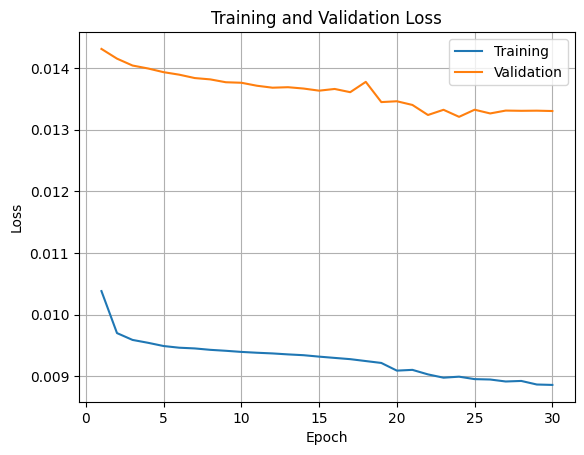

In [30]:
import matplotlib.pyplot as plt

epoch_list = [i for i in range(1, epochs+1)]

plt.plot(epoch_list, train_loss_list, label='Training', linestyle='-')

# 검증 손실 그래프
plt.plot(epoch_list, valid_loss_list, label='Validation', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

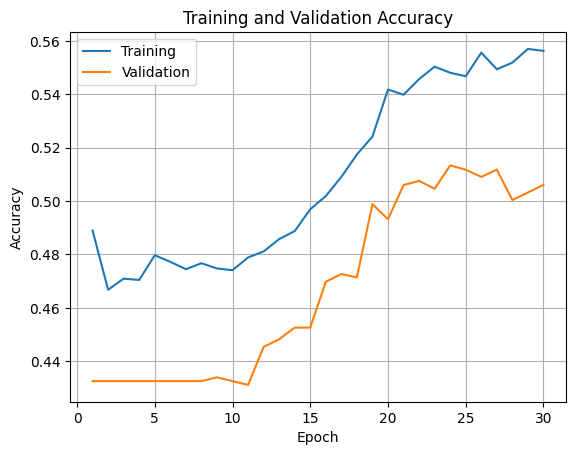

In [31]:
import matplotlib.pyplot as plt

epoch_list = [i for i in range(1, epochs+1)]

plt.plot(epoch_list, train_acc_list, label='Training', linestyle='-')

# 검증 손실 그래프
plt.plot(epoch_list, valid_acc_list, label='Validation', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

epoch_list = [i for i in range(1, epochs+1)]

plt.plot(epoch_list, train_acc_list, label='Training', linestyle='-')

# 검증 손실 그래프
plt.plot(epoch_list, valid_acc_list, label='Validation', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 4. Evaluation

In [25]:
check_point = "ckpt_biLSTM/model_test/ckpt-30.pt"

ckpt = torch.load(check_point)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [26]:
model.eval()
progress_bar = tqdm(range(len(test_dataloader)))
test_loss = 0
acc = 0
for batch in test_dataloader:
    past_values = batch['past_values'].to(device)
    future_values = batch['future_values'].to(device)
    
    outputs = model(past_values)
    sum_future_values = torch.sum(future_values, dim=1)
    loss = loss_fn(outputs.squeeze(), sum_future_values)

    pred = outputs.squeeze()
    label = sum_future_values
    acc += sum(pred * label > 0).item()
    
    progress_bar.update(1)

    test_loss += loss
    
test_loss /= len(test_dataloader)
acc /= len(test_dataset)
print(f"test loss: {test_loss:.7f}, test accuracy: {acc:.3f}")

  0%|          | 0/35 [00:00<?, ?it/s]

test loss: 0.0098725, test accuracy: 0.567


# 5. Load Model and Prediction

In [213]:
context_length = 120 # 모델이 참조할 데이터 길이 (original: 512)
forecast_horizon = 20 # 모델이 예측할 데이터 길이 (original: 96)
patch_length = 15 # 모델의 patch 길이. context_length의 약수여야 한다. (original: 16)
num_workers = 1 # dataloader worker 개수

In [214]:
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = PatchTSMixerConfig(
    context_length=context_length,
    prediction_length=forecast_horizon,
    patch_length=patch_length,
    num_input_channels=6, # close, high, low, open, volume, stock_log_return
    patch_stride=patch_length,
    d_model=16,
    num_layers=8,
    expansion_factor=2,
    dropout=0.2,
    head_dropout=0.2,
    mode="common_channel",
    scaling="std",
    prediction_channel_indices=[5] # 'stock_log_return'만을 예측하도록 하자.
)

ts_model = PatchTSMixerForPrediction(config)
ts_model.to(device)

PatchTSMixerForPrediction(
  (model): PatchTSMixerModel(
    (encoder): PatchTSMixerEncoder(
      (patcher): Linear(in_features=15, out_features=16, bias=True)
      (mlp_mixer_encoder): PatchTSMixerBlock(
        (mixers): ModuleList(
          (0-7): 8 x PatchTSMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): PatchTSMixerNormLayer(
                (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): PatchTSMixerMLP(
                (fc1): Linear(in_features=8, out_features=16, bias=True)
                (dropout1): Dropout(p=0.2, inplace=False)
                (fc2): Linear(in_features=16, out_features=8, bias=True)
                (dropout2): Dropout(p=0.2, inplace=False)
              )
              (gating_block): PatchTSMixerGatedAttention(
                (attn_layer): Linear(in_features=8, out_features=8, bias=True)
                (attn_softmax): Softmax(dim=-1)
              )
            )
          

In [215]:
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class CustomModel(nn.Module):
    def __init__(self, ts_model=ts_model):
        super().__init__()
        self.ts_model = ts_model

    def forward(self, past_values):
        prediction = self.ts_model(past_values=past_values)
        return prediction

model = CustomModel()

model.to(device)

CustomModel(
  (ts_model): PatchTSMixerForPrediction(
    (model): PatchTSMixerModel(
      (encoder): PatchTSMixerEncoder(
        (patcher): Linear(in_features=15, out_features=16, bias=True)
        (mlp_mixer_encoder): PatchTSMixerBlock(
          (mixers): ModuleList(
            (0-7): 8 x PatchTSMixerLayer(
              (patch_mixer): PatchMixerBlock(
                (norm): PatchTSMixerNormLayer(
                  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
                )
                (mlp): PatchTSMixerMLP(
                  (fc1): Linear(in_features=8, out_features=16, bias=True)
                  (dropout1): Dropout(p=0.2, inplace=False)
                  (fc2): Linear(in_features=16, out_features=8, bias=True)
                  (dropout2): Dropout(p=0.2, inplace=False)
                )
                (gating_block): PatchTSMixerGatedAttention(
                  (attn_layer): Linear(in_features=8, out_features=8, bias=True)
                  (attn_s

In [79]:
check_point = "ckpt/model_02/ckpt-16.pt"

ckpt = torch.load(check_point)
model.load_state_dict(ckpt['model'])

FileNotFoundError: [Errno 2] No such file or directory: 'ckpt/model_02/ckpt-16.pt'

In [80]:
test_sample = test_dataset[-1]
print(test_sample)

{'past_values': tensor([[ 7.0255e-01,  7.2037e-01,  7.1189e-01,  6.1386e-01, -2.9464e-01],
        [ 7.0255e-01,  6.8959e-01,  5.8505e-01,  5.2000e-01, -2.2122e-01],
        [ 8.8961e-01,  9.0505e-01,  9.0215e-01,  7.7028e-01, -8.2232e-02],
        [ 6.4020e-01,  6.5881e-01,  6.4847e-01,  7.3900e-01,  7.7452e-03],
        [ 6.7138e-01,  8.4349e-01,  7.1189e-01,  8.9542e-01, -1.5248e-01],
        [ 8.5843e-01,  7.8193e-01,  7.4360e-01,  6.7643e-01,  8.1916e-01],
        [ 8.8961e-01,  8.1271e-01,  9.0215e-01,  8.0157e-01, -2.6344e-01],
        [ 9.8314e-01,  9.6661e-01,  1.0290e+00,  1.1144e+00, -3.1898e-01],
        [ 7.0255e-01,  7.8193e-01,  8.3873e-01,  9.2670e-01, -2.2350e-01],
        [ 5.4667e-01,  5.6646e-01,  6.4847e-01,  5.8257e-01, -2.6066e-01],
        [ 3.5962e-01,  3.8178e-01,  3.9479e-01,  4.2615e-01,  4.0206e-01],
        [ 2.6609e-01,  4.7412e-01,  3.6308e-01,  5.8257e-01,  1.4247e-01],
        [ 1.1021e-01,  2.5866e-01,  2.3624e-01,  3.0101e-01, -3.3118e-02],
        [

In [222]:
past_values = test_sample["past_values"].unsqueeze(0).to(device)
outputs = model(past_values=past_values) # 2차원 텐서가 아닌 3차원 텐서로 입력되어야 함.
outputs.prediction_outputs # 예측

tensor([[[-0.0048],
         [-0.0043],
         [-0.0074],
         [-0.0007],
         [-0.0080],
         [-0.0064],
         [-0.0051],
         [-0.0078],
         [ 0.0003],
         [-0.0045],
         [-0.0106],
         [-0.0057],
         [ 0.0004],
         [-0.0100],
         [ 0.0044],
         [-0.0001],
         [-0.0048],
         [-0.0026],
         [-0.0056],
         [ 0.0032]]], device='cuda:0', grad_fn=<AddBackward0>)

In [223]:
test_sample["future_values"] # 정답

tensor([-0.0054, -0.0065,  0.0161,  0.0064, -0.0542, -0.0214, -0.0383, -0.0024,
         0.0036, -0.0191, -0.0356,  0.0050,  0.0330, -0.0430, -0.0013, -0.0267,
         0.0039, -0.0169,  0.0013,  0.0595])